In [2]:
import math
import torch
import torch.nn as nn

class InputEmbedding(nn.Module):
    def __init__(self,d_model:int,vocab_size:int):
        super().__init__()
        self.d_model=d_model
        self.vocab_size=vocab_size
        self.embedding=nn.Embedding(vocab_size,d_model)

    def forward(self,x):
        return self.embedding(x)*math.sqrt(self.d_model)
    

class PositionalEncoding(nn.Module):
    def __init__(self,d_model:int,seq_len :int,dropout:float) -> None:
        super().__init__()
        self.d_model=d_model
        self.seq_len==seq_len
        self.dropout=dropout

        # create a Matrix of shape (seq_len,d_model)
        pe=torch.zeros(seq_len,d_model)
        # Create a vector of shape (seq_len,1)
        position=torch.arange(0,seq_len,dtype=torch.float).unsqueeze(1)
        div_term=torch.exp(torch.arange(0,d_model,2).float() *(-math.log(10000.0)/d_model))
        # Apply the sine to even position
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)

        # add the batch dimension
        pe=pe.unsqueeze(0) # (1,seq_len,d_model)

        # when you want to save a tensor as file you should register_buffer
        self.register_buffer("pe",pe)
    def forward(self,x):
        # we dont want to learn the positional encoding parameters it is always fixed
        x=x+(self.pe[:,:x.shape[1],:]).requires_grad_(False)
        return self.dropout(x)
    
    


    


    



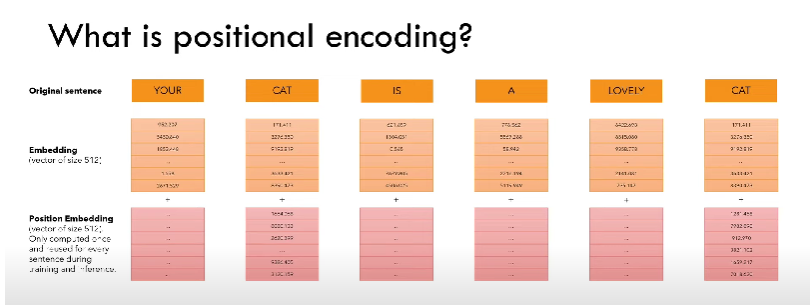
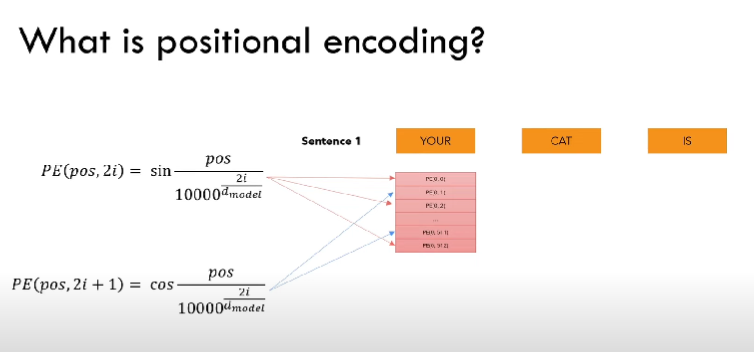
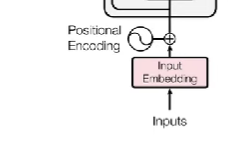

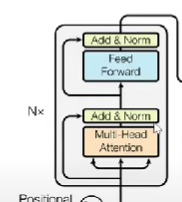
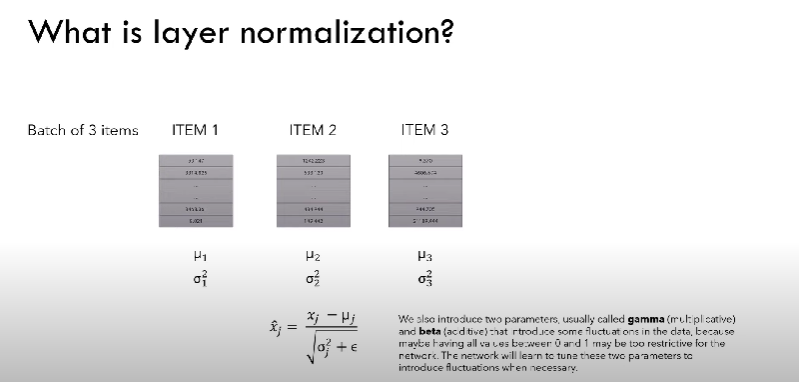

In [3]:
class LayerNormalization(nn.Module):
    def __init__(self,eps:float=10**-6) -> None:
        self.eps=eps
        self.alpha=nn.Parameter(torch.ones(1)) # Multiplied
        self.bias=nn.Parameter(torch.zeros(1)) # added

    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True)
        std=x.std(dim=-1,keepdim=True)

        return self.alpha * (x-mean) /(std +self.eps) +self.bias
    




In [4]:
class FeedForwardBlock(nn.Module):
    def __init__(self,d_model,d_ff,dropout):
        super().__init__()
        self.linear1=nn.Linear(d_model,d_ff) # W1, B1
        self.dropout=nn.Dropout(dropout)
        self.linear2=nn.Linear(d_ff,d_model) #W2, B2


    def forward(self,x):
        # (Batch , seq_len, d_model) -> (Batch,seq_len,d_ff) --> (Batch, seq_len, d_model)

        return self.linear2(self.dropout(torch.relu(self.linear1(x))))
    

# Muktihead Attention Block
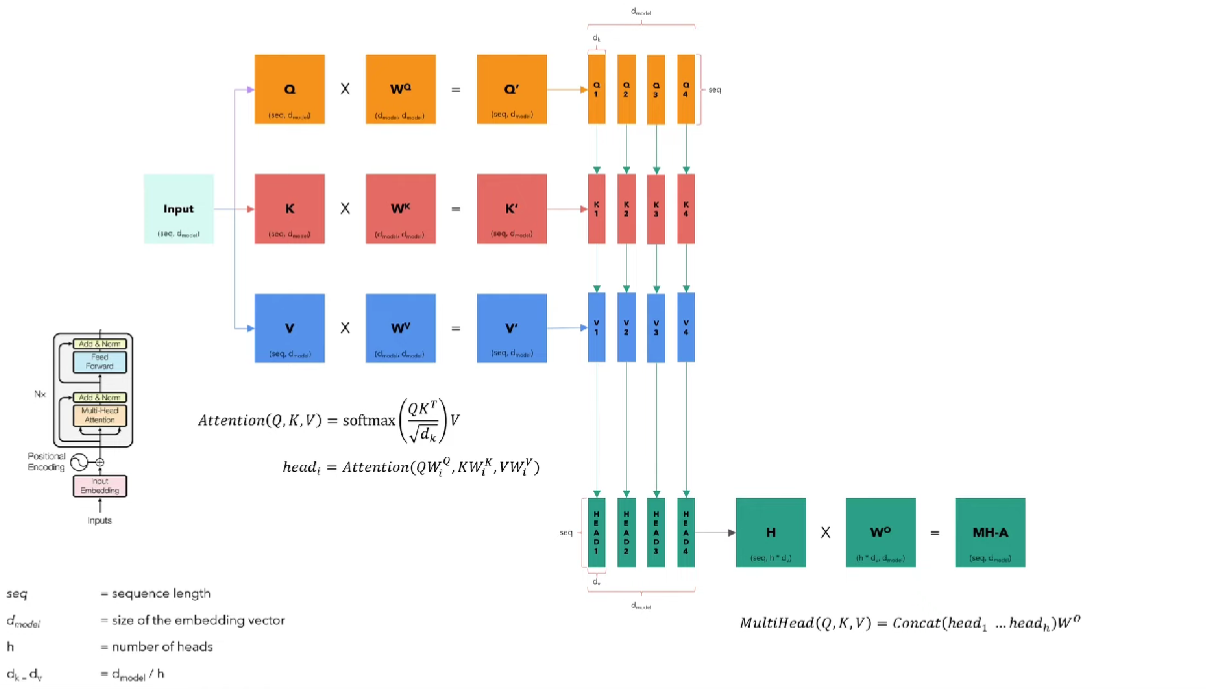

In [5]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self,d_model:int,h:int,dropout:float) ->None:
        super().__init__()
        self.d_model=d_model
        self.h=h

        assert d_model % h ==0 , "d_model is not divisible by h"
        self.d_k =d_model //h
        self.w_q=nn.Linear(d_model,d_model)
        self.w_k=nn.Linear(d_model,d_model)
        self.w_v=nn.Linear(d_model,d_model)

        self.w_o=nn.Linear(d_model,d_model)
        self.dropout=nn.Dropout(dropout)
    @staticmethod
    def attention(query,key,value,mask,dropout :nn.Dropout):
        d_k=query.shape[-1]

        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores=(query @ key.transpose(-2,-1))/math.sqrt(d_k)

        if mask is not None :
            attention_scores.masked_fill_(mask==0,-1e9)
        attention_scores=attention_scores.softmax(dim=-1)

        if dropout is not None:
            attention_scores=dropout(attention_scores)

        return (attention_scores @ value),attention_scores




    def forward(self,q,k,v,mask):
        query=self.w_q(q) # (Batch, seq_len,d_model) --> (Batch,Seq_len,d_model)
        key=self.w_k(k)   # (Batch, seq_len,d_model) --> (Batch,Seq_len,d_model)
        value=self.w_v(v) # (Batch, seq_len,d_model) --> (Batch,Seq_len,d_model)

        # divide all this matrces into smaller matrices
        #(batch , seq_len,d_model) --> (batch,seq_len,h,d_k) --> (batch,h,seq-len,d_k)
        query=query.view(query.shape[0],query.shape[1],self.h,self.d_k).transpose(1,2)
        key=key.view(key.shape[0],key.shape[1],self.h,self.d_k).transpose(1,2)
        value=value.view(value.shape[0],value.shape[1],self.h,self.d_k).transpose(1,2)

        x,self.attention_scores=MultiHeadAttentionBlock.attention(query,key,value,mask,self.dropout)

        # (batch , h, seq_len, d_k) --> (Batch,seq_len, h,d_k)
        x=x.transpose(1,2).contiguous().view(x.shape[0],-1,self.h*self.d_k)

        # (batch , seq_len, d_model) --> (Batch,seq_len,d_model)

        return self.w_o(x)
    

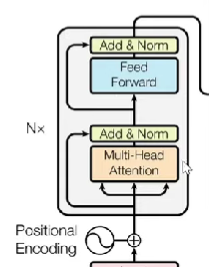

In [6]:
class ResidualConnection(nn.Module):
    def __init__(self,dropout :float):
        super().__init__()
        self.dropout=nn.Dropout(dropout)
        self.norm=LayerNormalization()

    def forward(self,x,sublayer):
        return x+self.dropout(sublayer(self.norm(x)))
        

In [7]:
class EncoderBlock(nn.Module):
    def __init__(self,self_attention_block : MultiHeadAttentionBlock,feed_forward_block : FeedForwardBlock,dropout :float):
        super().__init__()
        self.self_attention_block=self_attention_block
        self.feed_forward_block=feed_forward_block
        self.dropout=dropout
        self.residual_connections=nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])
        
    def forward(self,x,src_mask):
        x=self.residual_connections[0](x,lambda x : self.self_attention_block(x,x,x,src_mask))
        x=self.residual_connections[1](x,self.feed_forward_block)
        return x



In [8]:
class Encoder(nn.Module):
    def __init__(self,layers: nn.ModuleList):
        super().__init__()
        self.layers=layers
        self.norm=LayerNormalization()

    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)
    
    


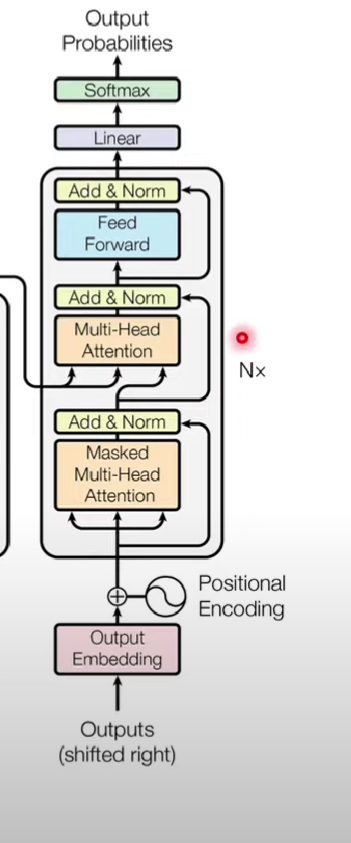

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self,self_attention_block:MultiHeadAttentionBlock,cross_attention_block:MultiHeadAttentionBlock,feed_forward_block : FeedForwardBlock,dropout:float):
        super().__init__()
        self.self_attention_block=self_attention_block
        self.cross_attention_block=cross_attention_block
        self.feed_forward_block=feed_forward_block
        self.residual_connections=nn.Module([ResidualConnection(dropout=dropout) for _ in range(3)])

    def forward(self,x,encoder_output,src_mask,tgt_mask):
        x=self.residual_connections[0](x,lambda x : self.self_attention_block(x,x,x,tgt_mask))
        x=self.residual_connections[1](x,lambda x: self.cross_attention_block(x,encoder_output,encoder_output,src_mask))
        x=self.residual_connections[2](x,self.feed_forward_block)
        return x
    
    




In [10]:
class Decoder(nn.Module):
    def __init__(self,layers : nn.ModuleList) -> None:
        super().__init__()
        self.layers=layers
        self.norm=LayerNormalization()

    def forward(self,x,encoder_output,src_mask,tgt_mask):
        for layer in self.layers:
            x=layer(x,encoder_output,src_mask,tgt_mask)
        return self.norm(x)


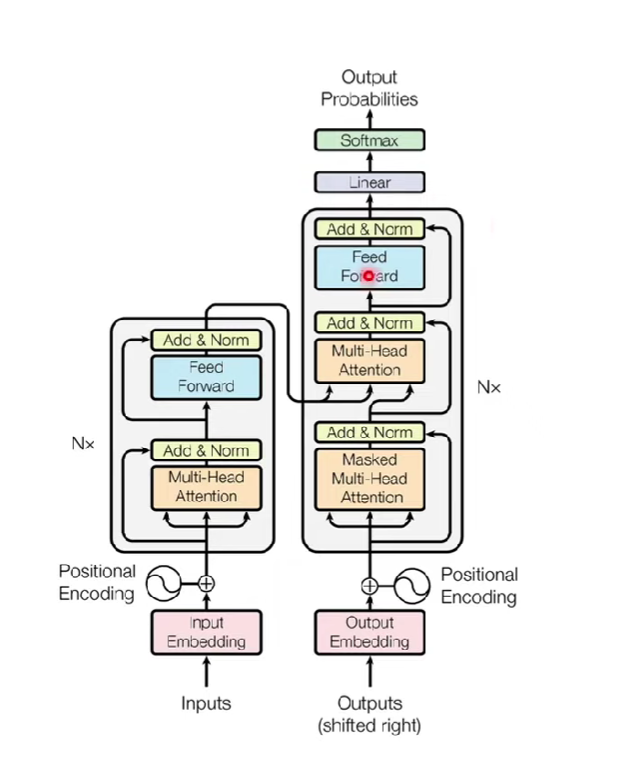

In [11]:
# Output of the Decoder is (batch_size,seq_len,d_model)
# We need the Linear Layer that will convert the embedding into a position of the vocabulary
# I will this layer the projection layer

In [12]:
class ProjectionLayer(nn.Module):
    def __init__(self,d_model : int,vocab_size:int):
        super().__init__()
        self.proj=nn.Linear(d_model,vocab_size)

    def forward(self,x):
        # (Batch,seq_len,d_model) ==> (Batch,seq_len,Vocab_size)
        return torch.log_softmax(self.proj(x),dim=-1)
    

In [15]:
class Transformer(nn.Module):
    def __init__(self,encoder: Encoder,decoder : Decoder,src_embed :InputEmbedding,tgt_embed : InputEmbedding , src_pos : PositionalEncoding,tgt_pos : PositionalEncoding,projection_layer : ProjectionLayer):
        super().__init__()
        self.encoder =encoder
        self.decoder=decoder
        self.src_embed=src_embed
        self.tgt_embed=tgt_embed
        self.src_pos=src_pos
        self.tgt_pos=tgt_pos
        self.projction_layer=projection_layer

    def encode(self,src,src_mask):
        src=self.src_embed(src)
        src=self.src_pos(src)
        return self.encoder(src,src_mask)

    def decode(self,encoder_output,src_mask,tgt,tgt_mask):
        tgt=self.tgt_embed(tgt)
        tgt=self.tgt_pos(tgt)
        return self.decoder(tgt,encoder_output,src_mask,tgt_mask)
    
    def project(self,x):
        return self.projection_layer(x)
    




In [16]:
def build_transformer(src_vocab_size : int , tgt_vocab_size:int,src_seq_len : int,tgt_seq_len : int,d_model: int=512,N :int =6,h:int =8,dropout:float =0.1,d_ff :int=2048)->Transformer:
    # Create the emmbedding layer
    src_embed=InputEmbedding(d_model,src_vocab_size)
    tgt_embed=InputEmbedding(d_model,tgt_vocab_size)

    # Positional Encoding Layers
    src_pos=PositionalEncoding(d_model,src_seq_len)
    tgt_pos=PositionalEncoding(d_model,tgt_seq_len,dropout)

    # Create the encoder blocks
    encoder_blocks=[]

    for _ in range(N):
        encoder_self_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
        feed_forwarrd_block=FeedForwardBlock(d_model,d_ff,dropout)
        encoder_block=EncoderBlock(encoder_self_attention_block,feed_forwarrd_block,dropout)
        encoder_blocks.append(encoder_block)

    decoder_blocks=[]

    for _ in range(N):
        decoder_self_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
        decoder_cross_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)

        feed_forward_block=FeedForwardBlock(d_model,d_ff,dropout)

        decoder_block=DecoderBlock(decoder_self_attention_block,decoder_cross_attention_block,feed_forward_block,dropout)
        decoder_blocks.append(decoder_block)

    # Create the encoder and Decoder
    encoder=Encoder(nn.ModuleList(encoder_blocks))
    decoder=Decoder(nn.ModuleList(decoder_blocks))

    #Craete the Projection Layer
    projection_layer=ProjectionLayer(d_model,tgt_vocab_size)

    # Create the Transformer\
    transformer=Transformer(encoder,decoder,src_embed,tgt_embed,src_pos,tgt_pos,projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1 :
            nn.init.xavier_uniform_(p)

    return transformer


